### find inversions with PCA

In [1]:
import allel
import zarr
import numpy as np
#import malariagen_data
import pandas as pd
import plotly.express as px
from tqdm.notebook import tqdm
import sgkit as sg
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style="whitegrid")


In [7]:
df_samples = pd.read_csv('/Users/dennistpw/Projects/AsGARD/metadata/cease_combinedmetadata_noqc.20250212.csv')
#palettes
# Palette - this maps onto the cohort labels in the dataframe above.
pop_code_cols = {
    'APA' : '#ff7f00', #orange
    'SAE' : '#6a3d9a', #dark purple
    'SAR' : '#cab2d6', #ligher purple
    'IRS' : '#c27a88', #horrible fuschia pink
    'IRH' : '#c57fc9', #salmon
    'INB' : '#96172e', #darkred
    'INM' : '#f03e5e', #lightred
    'DJI' : '#507d2a', #sap green
    'ETB' : '#007272', #cobalt turq
    'ETS' : '#33a02c',#green
    'ETW' : '#a6cee3',#cerulean
    'SUD' : '#fccf86',#ochre
    'YEM' : '#CC7722'#khaki
}

In [3]:
def pc1_along_genotype_array(ds, window_size,n_snps_per_window=None, sample_set=None, sample_query=None, metadata=df_samples, colour=None, title=None):
    """
    Calculates PC1 along a chrom, using a stepping window of size `window_size`. Either a chrom 
    ('2L', '3RL', etc) and a sample_set can be passed, 
    or a tuple of genotype array and position array can be passed.
    
    Parameters
    ----------
    chrom: str or tuple
        Either a string contig ('2L', '3RL', etc) and sample_set/sample_query can be passed which will invoke
        malariagen_data, or a list of both a genotype array and an array of genomic positions.
    window_size: int
        Size of the sliding window in snps.
    n_snps_per_window: int
        Number of snps to use in each window. If None, all snps are used.
    sample_set: str
        Sample set to use. If None, all samples are used.
    sample_query: str
        Sample query to use. If None, all samples in the sample set are used.
    metadata: pandas dataframe
        Metadata for the samples. Must be same length and order as genotype array. Columns can be used for plotting colours
    colour: str
        Column name in metadata to use for colouring the plot.
    """
    
    # subset to accessible sites
    accmask = ds['is_accessible'].compute()
    ds = ds.sel(variants=(accmask))

    geno = allel.GenotypeArray(ds['call_genotype'])
    pos = ds['variant_position'][:]

    
    
    #noyem_samples = metadata[metadata['state'] != 'Yemen']['order'].values #get sample locs
    #geno = geno.take(noyem_samples, axis=1)
    ac = geno.count_alleles()
    bial_ = ac.is_biallelic()
    print("found biallelics")
    geno = geno.compress(bial_, axis=0)
    gn_alt = geno.to_n_alt()
    
    print("removing any invariant sites")
    loc_var = np.any(gn_alt != gn_alt[:, 0, np.newaxis], axis=1)
    gn_var = np.compress(loc_var, gn_alt, axis=0)
    
    print("computing pcs")
    pc1s = allel.moving_statistic(values=gn_var, statistic=pca, size=window_size, n_snps_per_window=n_snps_per_window)
    midpoints = allel.moving_statistic(values=pos[bial_][loc_var], statistic=np.median, size=window_size)

    # Align to first window so all are consistent
    pc1s = align_pc1s_across_windows(pc1s)

    
    pc_df = pd.DataFrame(pc1s).T
    pc_df.columns = midpoints   
    pc_df = pd.concat([metadata, pc_df], axis=1)
    pc_df = pc_df.melt(id_vars=metadata.columns, var_name='midpoint', value_name='PC1')
    pc_df['PC1_scaled'] = pc_df.groupby('midpoint', group_keys=False)['PC1'].apply(lambda x: (x-np.mean(x))/(max(x)-min(x)))

    # Set plot style
    sns.set(style="ticks")

    # Create the plot
    plt.figure(figsize=(17, 5))
    sns.lineplot(data=pc_df, 
                x="midpoint", 
                y="PC1_scaled", 
                hue=colour, 
                units="sample_id",  # Ensures each individual gets its own line
                estimator=None,      # Prevents aggregation
                linewidth=0.5,       # Thinner lines
                palette=pop_code_cols, # Apply custom colors
                alpha=0.5)           # Transparency

    sns.despine()
    # Improve legend placement
    plt.legend(title="Cohort", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show plot
    plt.xlabel("Position")
    plt.ylabel("PC1_scaled")
    plt.title(title)
    plt.savefig(f'/Users/dennistpw/Projects/AsGARD/figures/{title}.svg', format='svg')
    plt.show()

    return(pc_df)

def pca(x, n_components=1, n_snps_per_window=None):

    """
    Performs PCA and returns the first principal component.
    """
    # optionally thin snps
    if n_snps_per_window:
        i_mask = np.random.choice(x.shape[0], n_snps_per_window)
        x = x.take(i_mask, axis=0)

    coords, _ = allel.pca(x, n_components=n_components)
    
    # flip axes back so PC1 is same orientation in each window 
    for i in range(n_components):
        c = coords[:, i]
    if np.abs(c.min()) > np.abs(c.max()):
        coords[:, i] = c * -1
                
    return(coords[:, 0])


def align_pc1s_across_windows(pc1s):
    """
    Ensures consistent PC1 orientation across windows by aligning to the first window.
    """
    reference_pc1 = pc1s[0]  # Use the first window as reference

    for i in range(1, len(pc1s)):
        if np.corrcoef(reference_pc1, pc1s[i])[0, 1] < 0:
            pc1s[i] *= -1  # Flip sign if correlation is negative

    return pc1s
    

In [4]:
df_samples = pd.read_csv('/Users/dennistpw/Projects/AsGARD/metadata/cease_combinedmetadata_noqc.20241228.csv')

In [5]:
chr2 = sg.load_dataset(f'/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/combined_cohorts.CM023248.zarr')
chr3 = sg.load_dataset(f'/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/combined_cohorts.CM023249.zarr')
chrX = sg.load_dataset(f'/Users/dennistpw/Projects/AsGARD/data/variants_combined_cohorts/combined_cohorts.CM023250.zarr')


found biallelics
removing any invariant sites
computing pcs


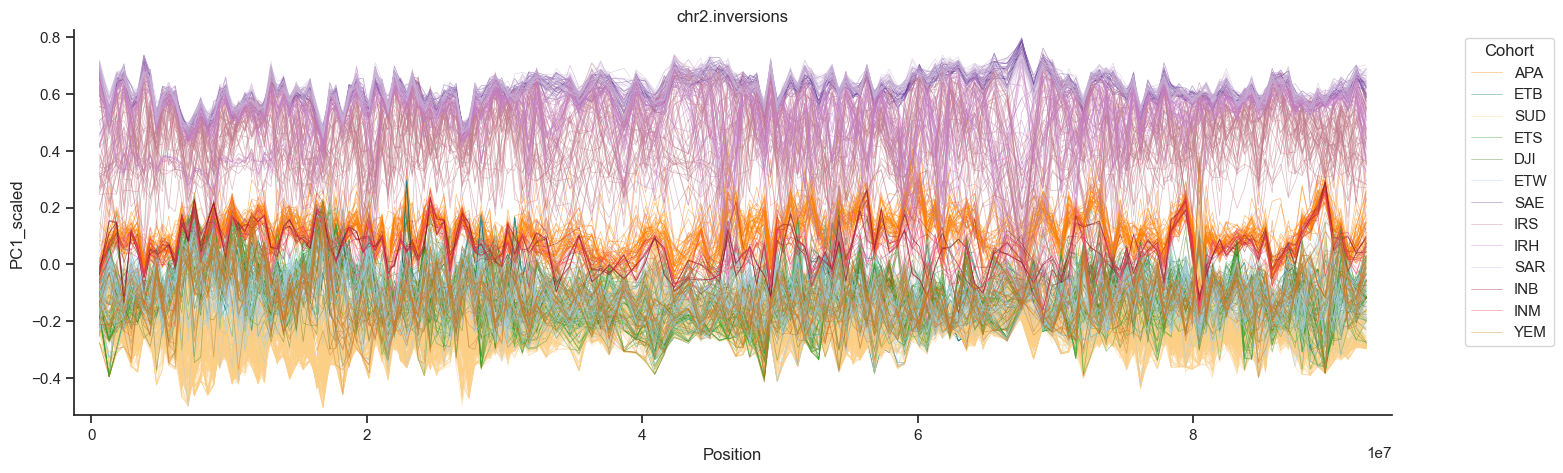

,callset_order,sample_id,conc (ng/ul),sequencing_date,sampleset_id,fastq_1_path,fastq_2_path,bam_path,vcf_path,legacy_id,...,analysis_pop,pop_code,SuperPopulation,collection_method,collection_date,reference,note,midpoint,PC1,PC1_scaled
0,0,AfNA1,5.30,13/11/2023,pak.afg.20231204,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,AfNA1,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",599613.5,1.459634,0.011284
1,1,AfNA2,NaN,13/11/2023,pak.afg.20231204,NaN,NaN,NaN,NaN,AfNA2,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",599613.5,-5.223497,-0.040391
2,2,AfNC4,2.60,13/11/2023,pak.afg.20231204,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,AfNC4,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",599613.5,-2.195618,-0.016979
3,3,AfNC7,2.50,13/11/2023,pak.afg.20231204,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,AfNC7,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",599613.5,-1.051435,-0.008132
4,4,AfND7,2.90,13/11/2023,pak.afg.20231204,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,AfND7,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",599613.5,4.620512,0.035724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93114,546,Yeme_A_13,12.53,28/04/2024,eth.djib.yem.20240606,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,Yeme_A_12_EKDN240018904-1A_22JVYWLT3_L7,...,Yemen,YEM,Horn of Africa & Yemen,CDC,01/07/2022,NaN,collected btw 07/2022-02/2023,92570460.5,-1.416518,-0.011133
93115,547,Yeme_A_14,20.47,28/04/2024,eth.djib.yem.20240606,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,Yeme_A_13_EKDN240018905-1A_223WLHLT4_L2,...,Yemen,YEM,Horn of Africa & Yemen,CDC,01/07/2022,NaN,collected btw 07/2022-02/2023,92570460.5,-14.559479,-0.114376
93116,548,Yeme_A_15,14.93,28/04/2024,eth.djib.yem.20240606,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,Yeme_A_14_EKDN240018906-1A_22JVYWLT3_L7,...,Yemen,YEM,Horn of Africa & Yemen,CDC,01/07/2022,NaN,collected btw 07/2022-02/2023,92570460.5,-7.557894,-0.059376
93117,549,Yeme_A_17,19.29,28/04/2024,eth.djib.yem.20240606,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,Yeme_A_15_EKDN240018907-1A_22772HLT4_L8,...,Yemen,YEM,Horn of Africa & Yemen,CDC,01/07/2022,NaN,collected btw 07/2022-02/2023,92570460.5,-4.512842,-0.035456


In [8]:
pc1_along_genotype_array(ds=chr2,
                         window_size=50_000,
                        n_snps_per_window=10_000,
                        colour='pop_code',
                        title='chr2.inversions'
                         )

found biallelics
removing any invariant sites
computing pcs


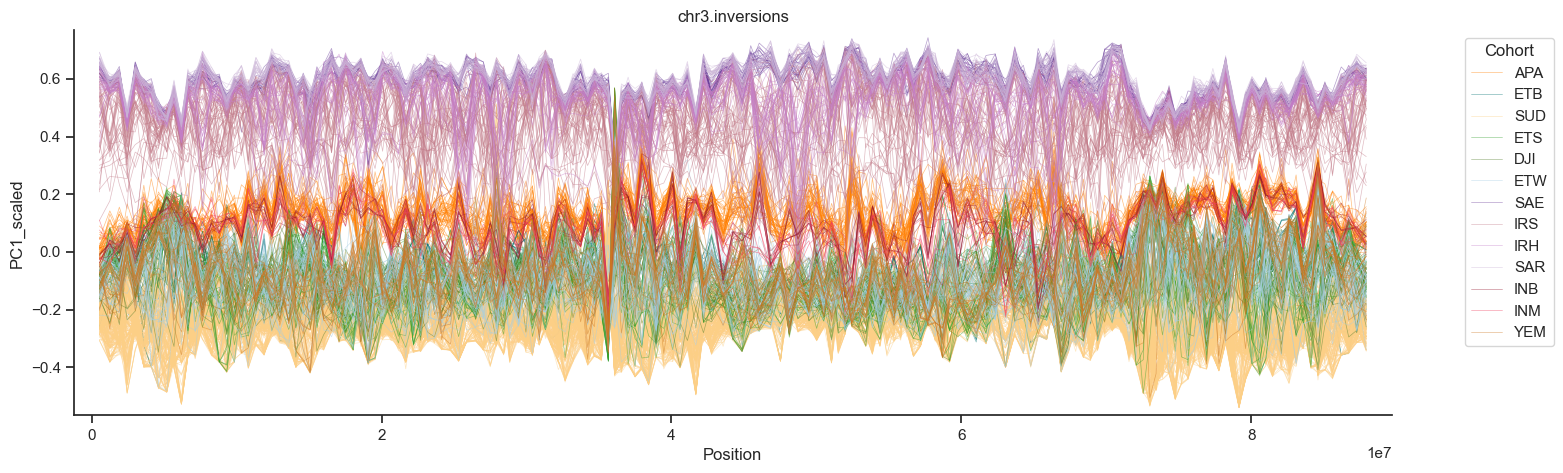

,callset_order,sample_id,conc (ng/ul),sequencing_date,sampleset_id,fastq_1_path,fastq_2_path,bam_path,vcf_path,legacy_id,...,analysis_pop,pop_code,SuperPopulation,collection_method,collection_date,reference,note,midpoint,PC1,PC1_scaled
0,0,AfNA1,5.30,13/11/2023,pak.afg.20231204,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,AfNA1,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",527099.0,11.343977,0.089881
1,1,AfNA2,NaN,13/11/2023,pak.afg.20231204,NaN,NaN,NaN,NaN,AfNA2,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",527099.0,1.174745,0.009301
2,2,AfNC4,2.60,13/11/2023,pak.afg.20231204,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,AfNC4,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",527099.0,-0.477602,-0.003791
3,3,AfNC7,2.50,13/11/2023,pak.afg.20231204,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,AfNC7,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",527099.0,2.402631,0.019031
4,4,AfND7,2.90,13/11/2023,pak.afg.20231204,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,AfND7,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",527099.0,5.412374,0.042880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93114,546,Yeme_A_13,12.53,28/04/2024,eth.djib.yem.20240606,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,Yeme_A_12_EKDN240018904-1A_22JVYWLT3_L7,...,Yemen,YEM,Horn of Africa & Yemen,CDC,01/07/2022,NaN,collected btw 07/2022-02/2023,87941211.5,10.565817,0.089011
93115,547,Yeme_A_14,20.47,28/04/2024,eth.djib.yem.20240606,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,Yeme_A_13_EKDN240018905-1A_223WLHLT4_L2,...,Yemen,YEM,Horn of Africa & Yemen,CDC,01/07/2022,NaN,collected btw 07/2022-02/2023,87941211.5,9.824347,0.082764
93116,548,Yeme_A_15,14.93,28/04/2024,eth.djib.yem.20240606,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,Yeme_A_14_EKDN240018906-1A_22JVYWLT3_L7,...,Yemen,YEM,Horn of Africa & Yemen,CDC,01/07/2022,NaN,collected btw 07/2022-02/2023,87941211.5,-26.264473,-0.221250
93117,549,Yeme_A_17,19.29,28/04/2024,eth.djib.yem.20240606,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,Yeme_A_15_EKDN240018907-1A_22772HLT4_L8,...,Yemen,YEM,Horn of Africa & Yemen,CDC,01/07/2022,NaN,collected btw 07/2022-02/2023,87941211.5,-1.878007,-0.015817


In [9]:
pc1_along_genotype_array(ds=chr3,
                         window_size=50_000,
                        n_snps_per_window=10_000,
                        colour='pop_code',
                        title='chr3.inversions'
                         )

found biallelics
removing any invariant sites
computing pcs


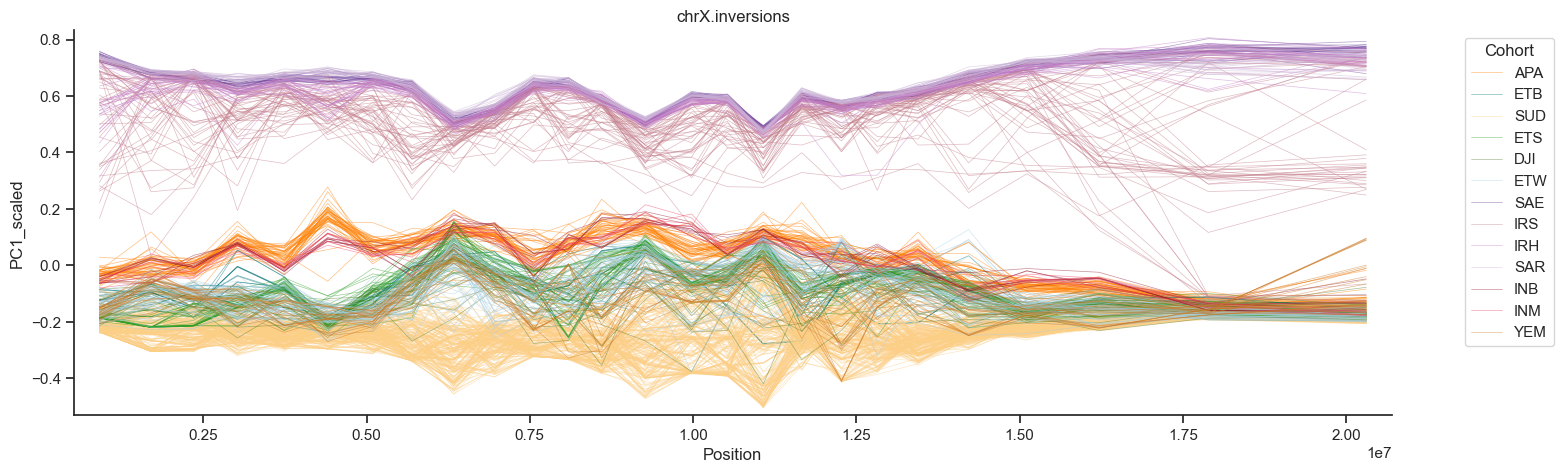

,callset_order,sample_id,conc (ng/ul),sequencing_date,sampleset_id,fastq_1_path,fastq_2_path,bam_path,vcf_path,legacy_id,...,analysis_pop,pop_code,SuperPopulation,collection_method,collection_date,reference,note,midpoint,PC1,PC1_scaled
0,0,AfNA1,5.30,13/11/2023,pak.afg.20231204,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,AfNA1,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",910469.5,-7.088802,-0.046423
1,1,AfNA2,NaN,13/11/2023,pak.afg.20231204,NaN,NaN,NaN,NaN,AfNA2,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",910469.5,-3.080788,-0.020175
2,2,AfNC4,2.60,13/11/2023,pak.afg.20231204,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,AfNC4,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",910469.5,-11.260807,-0.073745
3,3,AfNC7,2.50,13/11/2023,pak.afg.20231204,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,AfNC7,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",910469.5,-0.748309,-0.004900
4,4,AfND7,2.90,13/11/2023,pak.afg.20231204,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,/home/dennist/lstm_data/cease/reads_gvcf/pak.a...,AfND7,...,Afghanistan & Pakistan,APA,Asia,larvae,01/01/2017,see https://malariajournal.biomedcentral.com/a...,"year approx. could be 2014,15 or 17",910469.5,-7.457222,-0.048836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14321,546,Yeme_A_13,12.53,28/04/2024,eth.djib.yem.20240606,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,Yeme_A_12_EKDN240018904-1A_22JVYWLT3_L7,...,Yemen,YEM,Horn of Africa & Yemen,CDC,01/07/2022,NaN,collected btw 07/2022-02/2023,20306687.5,-23.970602,-0.175321
14322,547,Yeme_A_14,20.47,28/04/2024,eth.djib.yem.20240606,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,Yeme_A_13_EKDN240018905-1A_223WLHLT4_L2,...,Yemen,YEM,Horn of Africa & Yemen,CDC,01/07/2022,NaN,collected btw 07/2022-02/2023,20306687.5,12.619197,0.092292
14323,548,Yeme_A_15,14.93,28/04/2024,eth.djib.yem.20240606,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,Yeme_A_14_EKDN240018906-1A_22JVYWLT3_L7,...,Yemen,YEM,Horn of Africa & Yemen,CDC,01/07/2022,NaN,collected btw 07/2022-02/2023,20306687.5,0.161281,0.001176
14324,549,Yeme_A_17,19.29,28/04/2024,eth.djib.yem.20240606,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,/home/dennist/lstm_data/cease/reads_gvcf/eth.y...,Yeme_A_15_EKDN240018907-1A_22772HLT4_L8,...,Yemen,YEM,Horn of Africa & Yemen,CDC,01/07/2022,NaN,collected btw 07/2022-02/2023,20306687.5,-5.386800,-0.039401


In [10]:
pc1_along_genotype_array(ds=chrX,
                         window_size=50_000,
                        n_snps_per_window=10_000,
                        colour='pop_code',
                        title='chrX.inversions'
                         )